***Welcome to Medical image processing in Python***<br/>

Presented by: Reza Saadatyar (2024-2025) <br/>
E-mail: Reza.Saadatyar@outlook.com<br/>
**[GitHub](https://github.com/RezaSaadatyar/Deep-Learning-in-python)**

In [1]:
# This code is specifically designed for Google Colab environment
# It clones a GitHub repository containing medical image processing code and sets up the environment

# Clone the Medical-Image-Processing repository from GitHub using git command
# In Colab, this will clone into the /content directory by default
!git clone https://github.com/RezaSaadatyar/Medical-Image-Processing

# List contents of the cloned repository directory to verify successful cloning
# Colab's !ls command shows files in the current directory
!ls /content/Medical-Image-Processing

# Change working directory to the Code subdirectory of the cloned repository
# %cd is a Colab magic command to change directories
%cd /content/Medical-Image-Processing/Code

# Import Python's system module for path manipulation
import sys

# Add the Functions subdirectory to Python's system path for module imports
# This allows importing custom modules from the cloned repository
sys.path.append('/content/Medical-Image-Processing/Code/Functions')

# Install the colorama package using pip for colored terminal text
# Colab's !pip install installs packages in the current runtime environment
! pip install colorama

Cloning into 'Medical-Image-Processing'...
remote: Enumerating objects: 9027, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 9027 (delta 5), reused 10 (delta 4), pack-reused 9016 (from 3)
Receiving objects: 100% (9027/9027), 1.05 GiB | 17.20 MiB/s, done.
Resolving deltas: 100% (3288/3288), done.
Updating files: 100% (7749/7749), done.
Code  Data  Image  LICENSE  README.md  Results
/content/Medical-Image-Processing/Code


<font color='#FF000e' size="4.8" face="Arial"><b>Importing libraries</b></font>

In [2]:
import pprint
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, Union

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import CSVLogger, ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

from Functions.image_processor import ImageProcessor
from Functions.filepath_extractor import FilePathExtractor
from Functions.prepare_dataset import prepare_dataset
from Functions.resunetplusplus_model import resunetplusplus_model
from Functions.segmentation_metrics import segmentation_metrics
from Functions.show_image_training_progress import ShowImageTrainingProgress
from Functions.plot_training_history import plot_training_history
from Functions.plot_evaluation_results import plot_evaluation_results
from Functions.evaluate_segmentation_predictions import evaluate_segmentation_predictions
from Functions.display_predictions import display_predictions

<font color=#eff30b size="4.5" face="Arial"><b>1️⃣ Project 1: Brain Tumor Image Segmentation</b></font>

Image shape: (3064, 256, 256, 1)
masks.shape = (3064, 256, 256, 1)
Total number of classes in masks: 2
Class counts in masks:
  Class 0.00: 197408980
  Class 1.00: 3393324
Training set:   (1838, 256, 256, 1) features, (1838, 256, 256, 1) labels
Validation set: (766, 256, 256, 1) features, (766, 256, 256, 1) labels
Test set:       (460, 256, 256, 1) features, (460, 256, 256, 1) labels

Batch size:     8
Training shuffle: enabled
	
(TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None))
Epoch 1/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - accuracy: 0.8974 - dice_coef: 0.0355 - iou: 0.0181 - loss: 0.4216 - precision: 0.0224 - recall: 0.1175
Epoch 1: val_loss improved from inf to 0.07961, saving model to BrainTumor_resunet_model.keras
150/150 ━━━━━━━━━━━━━━━━━━━━ 133s 363ms/step - accuracy: 0.8978 - dice_coef: 0.0356 - iou: 0.0182 - loss: 0.4203 - precision: 0.0224 - recall: 0.1170 - val_accuracy: 0.9832 -

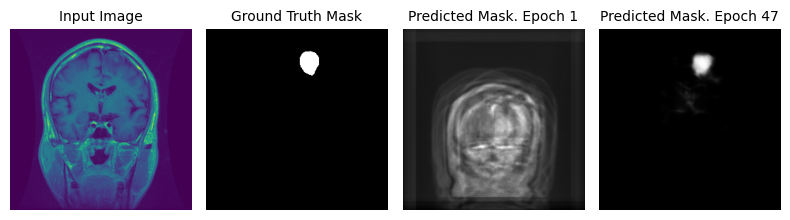

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - accuracy: 0.9923 - dice_coef: 0.7006 - iou: 0.5450 - loss: 0.0213 - precision: 0.7998 - recall: 0.7426
Sample 1 Accuracy: 0.993; IoU: 0.877; Dice coef: 0.934; Recall: 0.923; Precision: 0.946
Sample 2 Accuracy: 0.996; IoU: 0.841; Dice coef: 0.913; Recall: 0.953; Precision: 0.877
Sample 3 Accuracy: 0.985; IoU: 0.706; Dice coef: 0.828; Recall: 0.999; Precision: 0.706


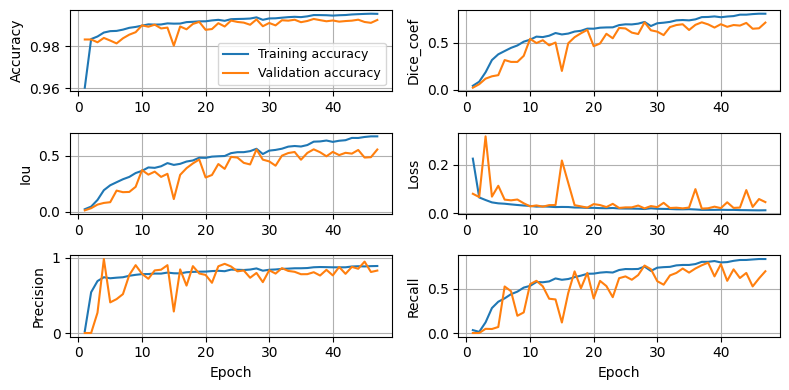

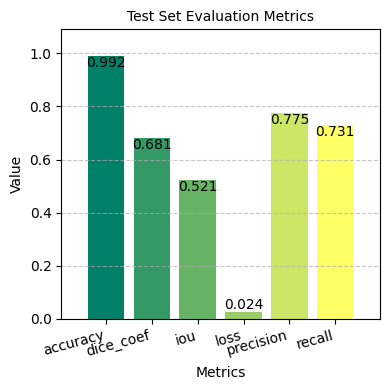

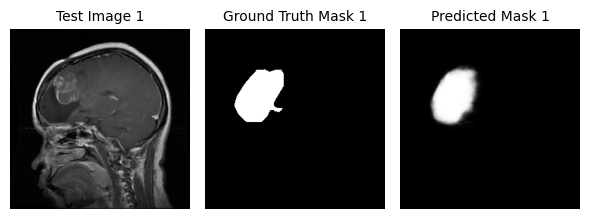

In [3]:
# ======================================= 1. Importing the dataset =============================================
# ------------------------------------------------ Images ------------------------------------------------------
img_format_type = "png"   # png, jpg, jpeg, tiff, bmp, tif, etc.
# image_path = "/content/Medical-Image-Processing/Data/Brain tumor/images"
image_path = "D:/Medical-Image-Processing/Data/Brain tumor/images/"

# Create an instance of DirectoryReader with the directory path and file format
obj_inputs = FilePathExtractor(directory_path=image_path, format_type=img_format_type)
img_filesname = obj_inputs.filesname         # List of filesname in the directory

# ------------------------------------------------ Masks -------------------------------------------------------
mask_format_type = "png"  # png, jpg, jpeg, tiff, bmp, tif, etc.

# mask_path = "/content/Medical-Image-Processing/Data/Brain tumor/masks"
mask_path = "D:/Medical-Image-Processing/Data/Brain tumor/masks/"

# Create an instance of DirectoryReader with the directory path and file format
obj_masks = FilePathExtractor(directory_path=mask_path, format_type=mask_format_type)
mask_filesname = obj_masks.filesname      # List of filesname in the directory

# -------------------------------------------- Check of the Images ---------------------------------------------
# Compare the base filenames (without extensions) of input files and mask files
# This line checks if the list of base filenames for input files matches the list of base filenames for mask files
[i.split(img_format_type)[0] for i in img_filesname] == [i.split(mask_format_type)[0] for i in mask_filesname]

# ============================ 2.Convert the images into array & masks to binary ===============================
# Create an instance of the `ImageProcessor` class
obj = ImageProcessor()

# Use the `read_images` method of the `ImageProcessor` object to load images from the directory
# The images are expected to be in "png or tif" format, and they are converted into a NumPy array
images = obj.read_images(image_path=image_path, format_type=img_format_type, resize=(256, 256), normalize=True)

# Use the `mask_read` method of the `ImageProcessor` object to load mask images from the directory
# The masks are expected to be in "TIF" format, and they are converted into a NumPy array
masks = obj.read_masks(mask_path=mask_path, format_type=mask_format_type, resize=(256, 256), normalize=True, num_classes=2)

# ===================== Prepare TensorFlow datasets for training, validation, and testing ======================
batch_size = 8

# Assuming data_resize and masks_resize are your input data and masks
train_dataset, valid_dataset, test_dataset = prepare_dataset(
    data=images,
    labels=masks,
    train_size=0.6,
    valid_size=0.25,
    batch_size=batch_size,
    shuffle_train=True,
    shuffle_buffer_size=1000,
)
train_dataset, valid_dataset, test_dataset = train_dataset.take(150), valid_dataset.take(50), test_dataset.take(20)
# ================================================= U-Net model ================================================
# Convert any tf.placeholder usage to tf.compat.v1.placeholder
tf.placeholder = tf.compat.v1.placeholder if hasattr(tf, 'placeholder') else None
img_height, img_width, img_channels = list(train_dataset.element_spec[0].shape[1:])
model = resunetplusplus_model(img_height,
                   img_width,
                   img_channels,
                   strides=1,
                   base_filters=16,
                   kernel_size=(3, 3),
                   shortcut_kernel_size=(1, 1),
                   n_class=1,
                  )
# model.summary()

# ======================================= Segmentation Metrics & compile =======================================
metrics = segmentation_metrics(alpha=0.1)
adam = Adam(learning_rate=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-7, amsgrad=False)
# Compile the model with custom loss and metrics
model.compile(
    optimizer=adam,               # Or 'adam', 'rmsprop'
    loss='binary_crossentropy', # Or binary_crossentropy, 'sparse_categorical_crossentropy', metrics['dice_coef_loss'], 'iou_coef_loss', 'combined_loss'
    metrics=[
        'accuracy',
        metrics['dice_coef'],
        metrics['iou'],
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.Precision(name='precision'),
        ],
    run_eagerly=False,  # Set run_eagerly=False for better performance
    )

 # ================================================ Callbacks ===================================================
# csv_path = os.path.join("files", "log.csv")
csv_path = 'training_log_BrainTumor_resunetplusplus.csv'  # File to log training metrics for UNet model
model_checkpoint_path = 'BrainTumor_resunetplusplus_model.keras'  # File to save the best UNet model

callbacks = [
    CSVLogger(csv_path),  # Logs metrics to a CSV file
    ModelCheckpoint(
        filepath=model_checkpoint_path,
        monitor='val_loss',   # Monitor validation loss
        verbose=1,            # Print when saving
        save_best_only=True   # Save only when val_loss improves
    ),
    ReduceLROnPlateau(
        monitor='val_loss',   # Monitor validation loss
        factor=0.1,           # Reduce learning rate by 10x
        patience=10,          # Wait 5 epochs without improvement
        min_lr=1e-6,          # Minimum learning rate
        verbose=1             # Print when reducing LR
    ),
    EarlyStopping(
        monitor='val_loss',         # Monitor validation loss
        patience=10,                # Stop after patience epochs without improvement
        restore_best_weights=True   # Restore best weights (changed to True for better results)
    ),
    ShowImageTrainingProgress(train_dataset, sample_idx=0, figsize=(8, 3.5)),  # Show the first sample in the batch
]

# ============================================ Training the model ==============================================
# Hyperparameters
num_epochs = 50
history = model.fit(
    train_dataset,
    epochs=num_epochs,
    callbacks=callbacks,
    validation_data=valid_dataset,
    shuffle=False,
    verbose=1,
)

# Evaluate on test set
results = model.evaluate(test_dataset, return_dict=True, verbose=1)

# ============================================ Test the model ==================================================
predictions = model.predict(test_dataset, verbose=0)
evaluate_segmentation_predictions(test_dataset=test_dataset, predictions=predictions, num_sample=3)

# ================================================ Results =====================================================
# Plot the history
plot_training_history(history, figsize=(8, 4))
plot_evaluation_results(results, figsize=(4, 4))

# Extract a small batch of data from test_dataset for visualization
for batch in test_dataset.take(1):
    test_images, test_masks = batch
    break

# Convert to numpy arrays for easier manipulation
test_images = test_images.numpy()
test_masks = test_masks.numpy()
display_predictions(test_images, test_masks, predictions, indx=0, figsize=(6, 4))

<font color= #ff25b2 size="4.5" face="Arial"><b>2️⃣ Project 2: Polyp Image Segmentation</b></font>

Image shape: (612, 288, 384, 3)
masks.shape = (612, 288, 384, 1)
Total number of classes in masks: 2
Class counts in masks:
  Class 0.00: 61387764
  Class 1.00: 6294540
Training set:   (367, 288, 384, 3) features, (367, 288, 384, 1) labels
Validation set: (153, 288, 384, 3) features, (153, 288, 384, 1) labels
Test set:       (92, 288, 384, 3) features, (92, 288, 384, 1) labels

Batch size:     8
Training shuffle: enabled
	
(TensorSpec(shape=(None, 288, 384, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 288, 384, 1), dtype=tf.float32, name=None))
Epoch 1/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7372 - dice_coef: 0.1951 - iou: 0.1091 - loss: 0.6411 - precision: 0.2233 - recall: 0.6281   
Epoch 1: val_loss improved from inf to 0.38499, saving model to Polyp_resunet_model.keras
46/46 ━━━━━━━━━━━━━━━━━━━━ 195s 2s/step - accuracy: 0.7389 - dice_coef: 0.1952 - iou: 0.1092 - loss: 0.6389 - precision: 0.2243 - recall: 0.6270 - val_accuracy: 0.9048 - val_dice_coef: 0.1

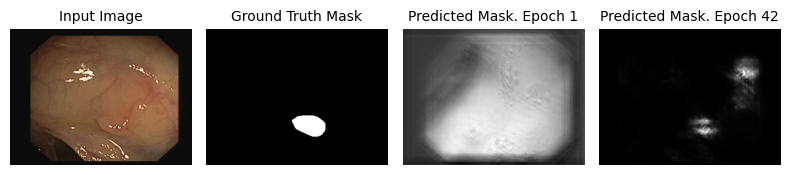

12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.9674 - dice_coef: 0.7028 - iou: 0.5460 - loss: 0.0971 - precision: 0.8389 - recall: 0.7030
Sample 1 Accuracy: 0.993; IoU: 0.846; Dice coef: 0.916; Recall: 0.933; Precision: 0.900
Sample 2 Accuracy: 0.985; IoU: 0.724; Dice coef: 0.840; Recall: 0.951; Precision: 0.752
Sample 3 Accuracy: 0.988; IoU: 0.000; Dice coef: 0.000; Recall: 0.000; Precision: 0.000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


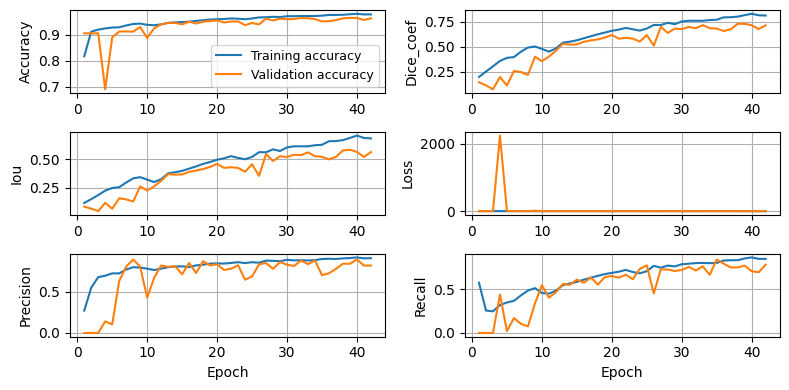

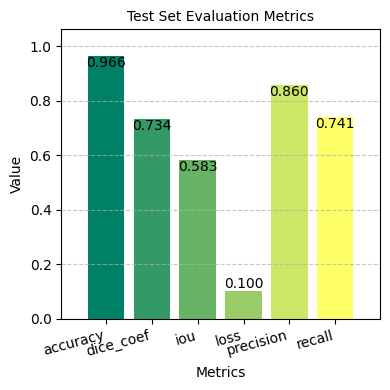

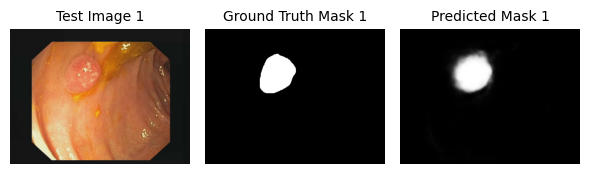

In [4]:
# ======================================= 1. Importing the dataset =============================================
# ------------------------------------------------ Images ------------------------------------------------------
img_format_type = "tif"   # png, jpg, jpeg, tiff, bmp, tif, etc.
# image_path = "/content/Medical-Image-Processing/Data/Polyp/images"
image_path = "D:/Medical-Image-Processing/Data/Polyp/images/"

# Create an instance of DirectoryReader with the directory path and file format
obj_inputs = FilePathExtractor(directory_path=image_path, format_type=img_format_type)
img_filesname = obj_inputs.filesname         # List of filesname in the directory

# ------------------------------------------------ Masks -------------------------------------------------------
mask_format_type = "tif"  # png, jpg, jpeg, tiff, bmp, tif, etc.

# mask_path = "/content/Medical-Image-Processing/Data/Polyp/masks"
mask_path = "D:/Medical-Image-Processing/Data/Polyp/masks/"

# Create an instance of DirectoryReader with the directory path and file format
obj_masks = FilePathExtractor(directory_path=mask_path, format_type=mask_format_type)
mask_filesname = obj_masks.filesname      # List of filesname in the directory

# -------------------------------------------- Check of the Images ---------------------------------------------
# Compare the base filenames (without extensions) of input files and mask files
# This line checks if the list of base filenames for input files matches the list of base filenames for mask files
[i.split(img_format_type)[0] for i in img_filesname] == [i.split(mask_format_type)[0] for i in mask_filesname]

# ============================ 2.Convert the images into array & masks to binary ===============================
# Create an instance of the `ImageProcessor` class
obj = ImageProcessor()

# Use the `read_images` method of the `ImageProcessor` object to load images from the directory
# The images are expected to be in "png or tif" format, and they are converted into a NumPy array
images = obj.read_images(image_path=image_path, format_type=img_format_type, resize=None, normalize=True)

# Use the `mask_read` method of the `ImageProcessor` object to load mask images from the directory
# The masks are expected to be in "TIF" format, and they are converted into a NumPy array
masks = obj.read_masks(mask_path=mask_path, format_type=mask_format_type, resize=None, normalize=True, num_classes=2)

# ===================== Prepare TensorFlow datasets for training, validation, and testing ======================
batch_size = 8

# Assuming data_resize and masks_resize are your input data and masks
train_dataset, valid_dataset, test_dataset = prepare_dataset(
    data=images,
    labels=masks,
    train_size=0.6,
    valid_size=0.25,
    batch_size=batch_size,
    shuffle_train=True,
    shuffle_buffer_size=1000,
)

# ================================================= U-Net model ================================================
# Convert any tf.placeholder usage to tf.compat.v1.placeholder
tf.placeholder = tf.compat.v1.placeholder if hasattr(tf, 'placeholder') else None
img_height, img_width, img_channels = list(train_dataset.element_spec[0].shape[1:])
model = resunetplusplus_model(img_height,
                   img_width,
                   img_channels,
                   strides=1,
                   base_filters=16,
                   kernel_size=(3, 3),
                   shortcut_kernel_size=(1, 1),
                   n_class=1,
                  )
# model.summary()

# ======================================= Segmentation Metrics & compile =======================================
metrics = segmentation_metrics(alpha=0.1)
adam = Adam(learning_rate=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-7, amsgrad=False)
# Compile the model with custom loss and metrics
model.compile(
    optimizer=adam,               # Or 'adam', 'rmsprop'
    loss='binary_crossentropy', # Or binary_crossentropy, 'sparse_categorical_crossentropy', metrics['dice_coef_loss'], 'iou_coef_loss', 'combined_loss'
    metrics=[
        'accuracy',
        metrics['dice_coef'],
        metrics['iou'],
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.Precision(name='precision'),
        ],
    run_eagerly=False,  # Set run_eagerly=False for better performance
    )

# ================================================ Callbacks ===================================================
# csv_path = os.path.join("files", "log.csv")
csv_path = 'training_log_Polyp_resunetplusplus.csv'  # File to log training metrics for UNet model
model_checkpoint_path = 'Polyp_resunetplusplus_model.keras'  # File to save the best UNet model

callbacks = [
    CSVLogger(csv_path),  # Logs metrics to a CSV file
    ModelCheckpoint(
        filepath=model_checkpoint_path,
        monitor='val_loss',   # Monitor validation loss
        verbose=1,            # Print when saving
        save_best_only=True   # Save only when val_loss improves
    ),
    ReduceLROnPlateau(
        monitor='val_loss',   # Monitor validation loss
        factor=0.1,           # Reduce learning rate by 10x
        patience=10,          # Wait 5 epochs without improvement
        min_lr=1e-6,          # Minimum learning rate
        verbose=1             # Print when reducing LR
    ),
    EarlyStopping(
        monitor='val_loss',         # Monitor validation loss
        patience=10,                # Stop after patience epochs without improvement
        restore_best_weights=True   # Restore best weights (changed to True for better results)
    ),
    ShowImageTrainingProgress(train_dataset, sample_idx=0, figsize=(8, 3.5)),  # Show the first sample in the batch
]

# ============================================ Training the model ==============================================
# Hyperparameters
num_epochs = 50
history = model.fit(
    train_dataset,
    epochs=num_epochs,
    callbacks=callbacks,
    validation_data=valid_dataset,
    shuffle=False,
    verbose=1,
)

# Evaluate on test set
results = model.evaluate(test_dataset, return_dict=True, verbose=1)

# ============================================ Test the model ==================================================
predictions = model.predict(test_dataset, verbose=0)
evaluate_segmentation_predictions(test_dataset=test_dataset, predictions=predictions, num_sample=3)

# ================================================ Results =====================================================
# Plot the history
plot_training_history(history, figsize=(8, 4))
plot_evaluation_results(results, figsize=(4, 4))

# Extract a small batch of data from test_dataset for visualization
for batch in test_dataset.take(1):
    test_images, test_masks = batch
    break

# Convert to numpy arrays for easier manipulation
test_images = test_images.numpy()
test_masks = test_masks.numpy()
display_predictions(test_images, test_masks, predictions, indx=0, figsize=(6, 4))

<font color= #gg25b2 size="4.5" face="Arial"><b>3️⃣ Project 3: Retina blood vessel Image Segmentation</b></font>

Image shape: (40, 512, 512, 3)
masks.shape = (40, 512, 512, 1)
Total number of classes in masks: 2
Class counts in masks:
  Class 0.00: 8278138
  Class 1.00: 2207622
Training set:   (27, 512, 512, 3) features, (27, 512, 512, 1) labels
Validation set: (10, 512, 512, 3) features, (10, 512, 512, 1) labels
Test set:       (3, 512, 512, 3) features, (3, 512, 512, 1) labels

Batch size:     2
Training shuffle: enabled
	
(TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 512, 512, 1), dtype=tf.float32, name=None))
Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5748 - dice_coef: 0.3565 - iou: 0.2171 - loss: 0.7015 - precision: 0.3155 - recall: 0.8306   
Epoch 1: val_loss improved from inf to 0.67367, saving model to RetinaBloodVessel_resunet_model.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.5758 - dice_coef: 0.3568 - iou: 0.2173 - loss: 0.6983 - precision: 0.3163 - recall: 0.8312 - val_accuracy: 0.5756 - val_dice_coef: 

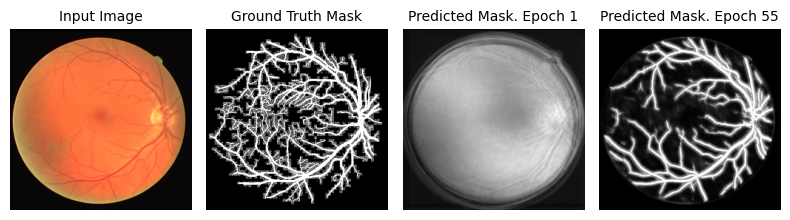

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.8795 - dice_coef: 0.5742 - iou: 0.4027 - loss: 0.2777 - precision: 0.7470 - recall: 0.5819
Sample 1 Accuracy: 0.879; IoU: 0.490; Dice coef: 0.658; Recall: 0.581; Precision: 0.758
Sample 2 Accuracy: 0.878; IoU: 0.475; Dice coef: 0.644; Recall: 0.566; Precision: 0.747


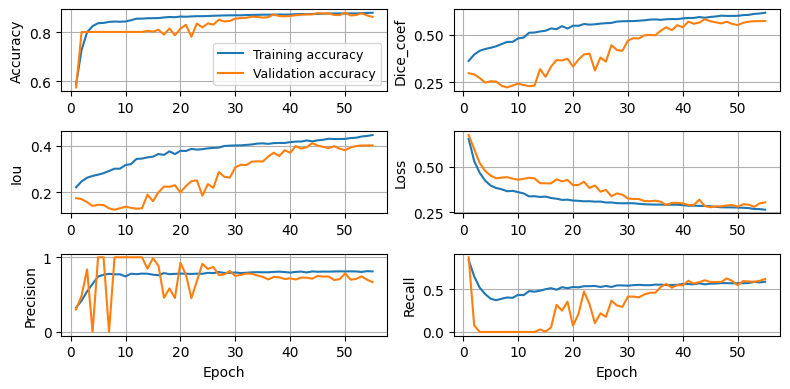

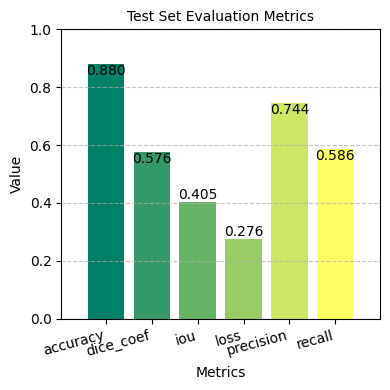

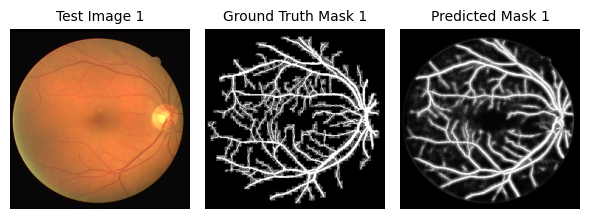

In [9]:
# ======================================= 1. Importing the dataset =============================================
# ------------------------------------------------ Images ------------------------------------------------------
img_format_type = "jpg"   # png, jpg, jpeg, tiff, bmp, tif, etc.
# image_path = "/content/Medical-Image-Processing/Data/Retina blood vessel/image"
image_path = "D:/Medical-Image-Processing/Data/Retina blood vessel/image/"

# Create an instance of DirectoryReader with the directory path and file format
obj_inputs = FilePathExtractor(directory_path=image_path, format_type=img_format_type)
img_filesname = obj_inputs.filesname         # List of filesname in the directory

# ------------------------------------------------ Masks -------------------------------------------------------
mask_format_type = "jpg"  # png, jpg, jpeg, tiff, bmp, tif, etc.

# mask_path = "/content/Medical-Image-Processing/Data/Retina blood vessel/mask"
mask_path = "D:/Medical-Image-Processing/Data/Retina blood vessel/mask/"

# Create an instance of DirectoryReader with the directory path and file format
obj_masks = FilePathExtractor(directory_path=mask_path, format_type=mask_format_type)
mask_filesname = obj_masks.filesname      # List of filesname in the directory

# -------------------------------------------- Check of the Images ---------------------------------------------
# Compare the base filenames (without extensions) of input files and mask files
# This line checks if the list of base filenames for input files matches the list of base filenames for mask files
[i.split(img_format_type)[0] for i in img_filesname] == [i.split(mask_format_type)[0] for i in mask_filesname]

# ============================ 2.Convert the images into array & masks to binary ===============================
# Create an instance of the `ImageProcessor` class
obj = ImageProcessor()

# Use the `read_images` method of the `ImageProcessor` object to load images from the directory
# The images are expected to be in "png or tif" format, and they are converted into a NumPy array
images = obj.read_images(image_path=image_path, format_type=img_format_type, resize=None, normalize=True)

# Use the `mask_read` method of the `ImageProcessor` object to load mask images from the directory
# The masks are expected to be in "TIF" format, and they are converted into a NumPy array
masks = obj.read_masks(mask_path=mask_path, format_type=mask_format_type, resize=None, normalize=True, num_classes=2)

# ===================== Prepare TensorFlow datasets for training, validation, and testing ======================
batch_size = 1

# Assuming data_resize and masks_resize are your input data and masks
train_dataset, valid_dataset, test_dataset = prepare_dataset(
    data=images,
    labels=masks,
    train_size=0.68,
    valid_size=0.25,
    batch_size=batch_size,
    shuffle_train=True,
    shuffle_buffer_size=1000,
)

# ================================================= U-Net model ================================================
# Convert any tf.placeholder usage to tf.compat.v1.placeholder
tf.placeholder = tf.compat.v1.placeholder if hasattr(tf, 'placeholder') else None
img_height, img_width, img_channels = list(train_dataset.element_spec[0].shape[1:])
model = resunetplusplus_model(img_height,
                   img_width,
                   img_channels,
                   strides=1,
                   base_filters=16,
                   kernel_size=(3, 3),
                   shortcut_kernel_size=(1, 1),
                   n_class=1,
                  )
# model.summary()

# ======================================= Segmentation Metrics & compile =======================================
metrics = segmentation_metrics(alpha=0.1)
adam = Adam(learning_rate=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-7, amsgrad=False)
# Compile the model with custom loss and metrics
model.compile(
    optimizer=adam,               # Or 'adam', 'rmsprop'
    loss='binary_crossentropy', # Or binary_crossentropy, 'sparse_categorical_crossentropy', metrics['dice_coef_loss'], 'iou_coef_loss', 'combined_loss'
    metrics=[
        'accuracy',
        metrics['dice_coef'],
        metrics['iou'],
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.Precision(name='precision'),
        ],
    run_eagerly=False,  # Set run_eagerly=False for better performance
    )

# ================================================ Callbacks ===================================================
# csv_path = os.path.join("files", "log.csv")
csv_path = 'training_log_RetinaBloodVessel_resunetplusplus.csv'  # File to log training metrics for UNet model
model_checkpoint_path = 'RetinaBloodVessel_resunetplusplus_model.keras'  # File to save the best UNet model

callbacks = [
    CSVLogger(csv_path),  # Logs metrics to a CSV file
    ModelCheckpoint(
        filepath=model_checkpoint_path,
        monitor='val_loss',   # Monitor validation loss
        verbose=1,            # Print when saving
        save_best_only=True   # Save only when val_loss improves
    ),
    ReduceLROnPlateau(
        monitor='val_loss',   # Monitor validation loss
        factor=0.1,           # Reduce learning rate by 10x
        patience=10,          # Wait 5 epochs without improvement
        min_lr=1e-6,          # Minimum learning rate
        verbose=1             # Print when reducing LR
    ),
    EarlyStopping(
        monitor='val_loss',         # Monitor validation loss
        patience=10,                # Stop after patience epochs without improvement
        restore_best_weights=True   # Restore best weights (changed to True for better results)
    ),
    ShowImageTrainingProgress(train_dataset, sample_idx=0, figsize=(8, 3.5)),  # Show the first sample in the batch
]

# ============================================ Training the model ==============================================
# Hyperparameters
num_epochs = 100
history = model.fit(
    train_dataset,
    epochs=num_epochs,
    callbacks=callbacks,
    validation_data=valid_dataset,
    shuffle=False,
    verbose=1,
)

# Evaluate on test set
results = model.evaluate(test_dataset, return_dict=True, verbose=1)

# ============================================ Test the model ==================================================
predictions = model.predict(test_dataset, verbose=0)
evaluate_segmentation_predictions(test_dataset=test_dataset, predictions=predictions, num_sample=2)

# ================================================ Results =====================================================
# Plot the history
plot_training_history(history, figsize=(8, 4))
plot_evaluation_results(results, figsize=(4, 4))

# Extract a small batch of data from test_dataset for visualization
for batch in test_dataset.take(1):
    test_images, test_masks = batch
    break

# Convert to numpy arrays for easier manipulation
test_images = test_images.numpy()
test_masks = test_masks.numpy()
display_predictions(test_images, test_masks, predictions, indx=0, figsize=(6, 4))